# 📚 Chapter 8: Introduction to Deep Learning

*This notebook contains the code examples in chapter 8. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

This chapter marks a segway across several domains. In chapters 1 through 7, we covered a sizeable swath of machine learning methods and how to apply them, typically using Scikit-Learn, to problems in drug discovery with a focus on ligand-based applications. In the second half, we will transition to advanced methods that underly deep learning. To apply these methods, we’ll expand our tool usage to PyTorch, a well-known and popular deep learning framework. Lastly, we’ll increase the scope of our projects to cover structure-based applications, e.g., how a ligand interacts with a known protein structure. 

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH08_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers:
- The kinase protein family from perspectives of both ligand- and structure-based virtual screening (VS)
- An introduction to PyTorch for constructing, training, and evaluating neural networks
- Theory underlying neural networks and common ways to improve their performance

## ⚙️ Part 0: Installation and Setup

**❗️NOTE:** After setting up a local environment, install the required packages via:
`!pip install -r https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/requirements.txt --quiet`

**❗️NOTE:** If running notebook via Colab, be sure to install RDKit via: `!pip install rdkit`

### Import and Setup Packages 

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import torch  # PyTorch library for tensor computations and neural networks
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F
import torch.optim as optim  # Optimization algorithms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader  # For handling datasets and data loading

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
colors = ["#A20025", "#6C8EBF", "#21130d"]
sns.set_palette(sns.color_palette(colors))

In [7]:
torch.__version__

'2.4.1+cu121'

In [8]:
torch.cuda.is_available()

False

In [4]:
# Set random seeds for deterministic resuluts
def seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed()

## 1️⃣ Ligand-based VS with PyTorch

### Our First PyTorch Model

In [7]:
tensor_2d = torch.tensor([[1, 2], [3, 4]])
print(f"Two-dimensional tensor: {tensor_2d}")
print(f"Shape of tensor: {tensor_2d.shape}")
print(f"Datatype of tensor: {tensor_2d.dtype}")
print(f"Device tensor is stored on: {tensor_2d.device}")

Two-dimensional tensor: tensor([[1, 2],
        [3, 4]])
Shape of tensor: torch.Size([2, 2])
Datatype of tensor: torch.int64
Device tensor is stored on: cpu


In [8]:
tensor_2d_float = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
print(f"Data type of tensor: {tensor_2d_float.dtype}")
tensor_2d_float = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32)
print(f"Data type of tensor: {tensor_2d_float.dtype}")

Data type of tensor: torch.float32
Data type of tensor: torch.float32


In [9]:
tensor_2d_float = tensor_2d.to(torch.float32)
print(f"Data type of tensor: {tensor_2d_float.dtype}")

Data type of tensor: torch.float32


In [10]:
tensor_df_mod = tensor_2d + 2
print(f"Modified two-dimensional tensor: {tensor_df_mod}")

Modified two-dimensional tensor: tensor([[3, 4],
        [5, 6]])


In [11]:
tensor_2d = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(f"Reshaped tensor: {tensor_2d.reshape(3, 2)}")
print(f"Original tensor: {tensor_2d}")

Reshaped tensor: tensor([[1, 2],
        [3, 4],
        [5, 6]])
Original tensor: tensor([[1, 2, 3],
        [4, 5, 6]])


In [12]:
tensor_2d = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(f"Reshaped tensor: {tensor_2d.view(3, 2)}")

Reshaped tensor: tensor([[1, 2],
        [3, 4],
        [5, 6]])


In [13]:
print(tensor_2d.T)

tensor([[1, 4],
        [2, 5],
        [3, 6]])


In [14]:
tensor = torch.ones(3, 3)
print(f"Tensor: {tensor}")
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(f"Modified tensor: {tensor}")
t1 = torch.cat([tensor, tensor], dim=1)
print(f"Row-wise concatenation of two tensors: {t1}")

Tensor: tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
First row: tensor([1., 1., 1.])
First column: tensor([1., 1., 1.])
Last column: tensor([1., 1., 1.])
Modified tensor: tensor([[1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.]])
Row-wise concatenation of two tensors: tensor([[1., 0., 1., 1., 0., 1.],
        [1., 0., 1., 1., 0., 1.],
        [1., 0., 1., 1., 0., 1.]])


In [15]:
print(tensor_2d.matmul(tensor_2d.T))
print(tensor_2d @ tensor_2d.T)

tensor([[14, 32],
        [32, 77]])
tensor([[14, 32],
        [32, 77]])


In [16]:
egfr_kinodata = pd.read_csv("data/CH08_EGFR-activities-chembl33.csv")

In [17]:
egfr_kinodata.head()

,Unnamed: 0.1,Unnamed: 0,activities.activity_id,assays.chembl_id,target_dictionary.chembl_id,molecule_dictionary.chembl_id,molecule_dictionary.max_phase,activities.standard_type,activities.standard_value,activities.standard_units,compound_structures.canonical_smiles,compound_structures.standard_inchi,component_sequences.sequence,assays.confidence_score,docs.chembl_id,docs.year,docs.authors,UniprotID
0,57,7654,1044894,CHEMBL683040,CHEMBL203,CHEMBL63786,NaN,pIC50,11.522879,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,InChI=1S/C18H12BrN3/c19-14-6-3-7-15(10-14)22-1...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,9,CHEMBL1129035,1996.0,"Rewcastle GW, Palmer BD, Bridges AJ, Showalter...",P00533
1,107,1064,191437,CHEMBL677389,CHEMBL203,CHEMBL35820,NaN,pIC50,11.221849,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,InChI=1S/C18H18BrN3O2/c1-3-23-16-9-14-15(10-17...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8,CHEMBL1130030,1997.0,"Palmer BD, Trumpp-Kallmeyer S, Fry DW, Nelson ...",P00533
2,108,7949,1082447,CHEMBL680021,CHEMBL203,CHEMBL53711,NaN,pIC50,11.221849,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,InChI=1S/C15H14BrN5/c1-21(2)14-7-12-13(8-17-14...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8,CHEMBL1129564,1996.0,"Rewcastle GW, Palmer BD, Thompson AM, Bridges ...",P00533
3,150,2936,428391,CHEMBL679944,CHEMBL203,CHEMBL66031,NaN,pIC50,11.096910,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,InChI=1S/C15H10BrN5/c16-9-2-1-3-10(4-9)21-15-1...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8,CHEMBL1132555,1999.0,"Showalter HD, Bridges AJ, Zhou H, Sercel AD, M...",P00533
4,151,2647,400160,CHEMBL679944,CHEMBL203,CHEMBL53753,NaN,pIC50,11.096910,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,InChI=1S/C14H12BrN5/c1-16-13-6-11-12(7-17-13)1...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8,CHEMBL1132555,1999.0,"Showalter HD, Bridges AJ, Zhou H, Sercel AD, M...",P00533


In [18]:
egfr_kinodata.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'activities.activity_id',
       'assays.chembl_id', 'target_dictionary.chembl_id',
       'molecule_dictionary.chembl_id', 'molecule_dictionary.max_phase',
       'activities.standard_type', 'activities.standard_value',
       'activities.standard_units', 'compound_structures.canonical_smiles',
       'compound_structures.standard_inchi', 'component_sequences.sequence',
       'assays.confidence_score', 'docs.chembl_id', 'docs.year',
       'docs.authors', 'UniprotID'],
      dtype='object')

In [19]:
# Keep necessary columns
egfr_kinodata = egfr_kinodata[["compound_structures.canonical_smiles", "activities.standard_value"]]
egfr_kinodata.head(10)

,compound_structures.canonical_smiles,activities.standard_value
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
5,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc21,11.000000
6,Cc1cc2cc(n1)-c1cnn(C)c1OCCC[C@@H](C)CN1/C(=N/C...,10.698970
7,Cn1cnc2cc3c(Nc4cccc(Br)c4)ncnc3cc21,10.602060
8,C#CCNC/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N...,10.522879
9,C=CC(=O)Nc1ccc2ncnc(Nc3cc(Cl)c(Cl)cc3F)c2c1,10.431798


In [20]:
egfr_kinodata.describe()

,activities.standard_value
count,7287.000000
mean,6.905357
std,1.445112
min,1.602060
25%,5.853872
50%,7.000000
75%,8.017729
max,11.522879


In [21]:
smiles, activities = egfr_kinodata["compound_structures.canonical_smiles"], egfr_kinodata["activities.standard_value"]

In [22]:
# Scaffold split
def scaffold_split(smiles, activities, test_size=0.2, random_state=42):
    mols, filtered_smiles = [], []
    for s in smiles:
        try:
            mols.append(Chem.MolFromSmiles(s))
            filtered_smiles.append(s)
        except:
            continue

    scaffolds = {}
    for i, mol in enumerate(mols):
        scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=True)
        if scaffold not in scaffolds:
            scaffolds[scaffold] = [i]
        else:
            scaffolds[scaffold].append(i)
    
    scaffold_sets = list(scaffolds.values())
    train_idx, test_idx = train_test_split(scaffold_sets, test_size=test_size, random_state=random_state)
    
    train_idx = [idx for set_idx in train_idx for idx in set_idx]
    test_idx = [idx for set_idx in test_idx for idx in set_idx]
    
    return [filtered_smiles[i] for i in train_idx], [activities[i] for i in train_idx], \
           [filtered_smiles[i] for i in test_idx], [activities[i] for i in test_idx]

train_smiles, train_activities, test_smiles, test_activities = scaffold_split(smiles, activities)

In [23]:
len(train_smiles)

5983

In [24]:
train_smiles, val_smiles, train_activities, val_activities = train_test_split(
        train_smiles, train_activities, test_size=0.1, random_state=42)

In [25]:
# Feature extraction
def smiles_to_fp(smiles, fp_size=2048):
    mol = Chem.MolFromSmiles(smiles)
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=fp_size)
    return np.array(mfpgen.GetFingerprint(mol))

# Dataset class
class MoleculeDataset(Dataset):
    def __init__(self, smiles, activities):
        self.smiles = smiles
        self.activities = activities
        self.fingerprints = [smiles_to_fp(s) for s in smiles]
        
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        fp = torch.tensor(self.fingerprints[idx], dtype=torch.float32)
        activity = torch.tensor([self.activities[idx]], dtype=torch.float32)
        return fp, activity

# Create datasets and dataloaders
train_dataset = MoleculeDataset(train_smiles, train_activities)
val_dataset = MoleculeDataset(val_smiles, val_activities)
test_dataset = MoleculeDataset(test_smiles, test_activities)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# Neural Network model
class KinaseBinderNN(nn.Module):
    def __init__(self, input_size=2048):
        super(KinaseBinderNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KinaseBinderNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
print(model)

KinaseBinderNN(
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [17]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

1180673

In [21]:
print(list(model.parameters())[0])

Parameter containing:
tensor([[ 0.0169,  0.0183, -0.0052,  ...,  0.0005,  0.0040,  0.0208],
        [ 0.0103,  0.0048, -0.0045,  ...,  0.0077, -0.0130,  0.0001],
        [-0.0157,  0.0178,  0.0186,  ..., -0.0200, -0.0149, -0.0048],
        ...,
        [ 0.0157, -0.0153, -0.0149,  ..., -0.0067, -0.0204,  0.0115],
        [-0.0076, -0.0050,  0.0033,  ..., -0.0127, -0.0035, -0.0135],
        [ 0.0167, -0.0090,  0.0154,  ...,  0.0088,  0.0171, -0.0183]],
       requires_grad=True)


In [20]:
print(list(model.parameters())[0].shape)

torch.Size([512, 2048])


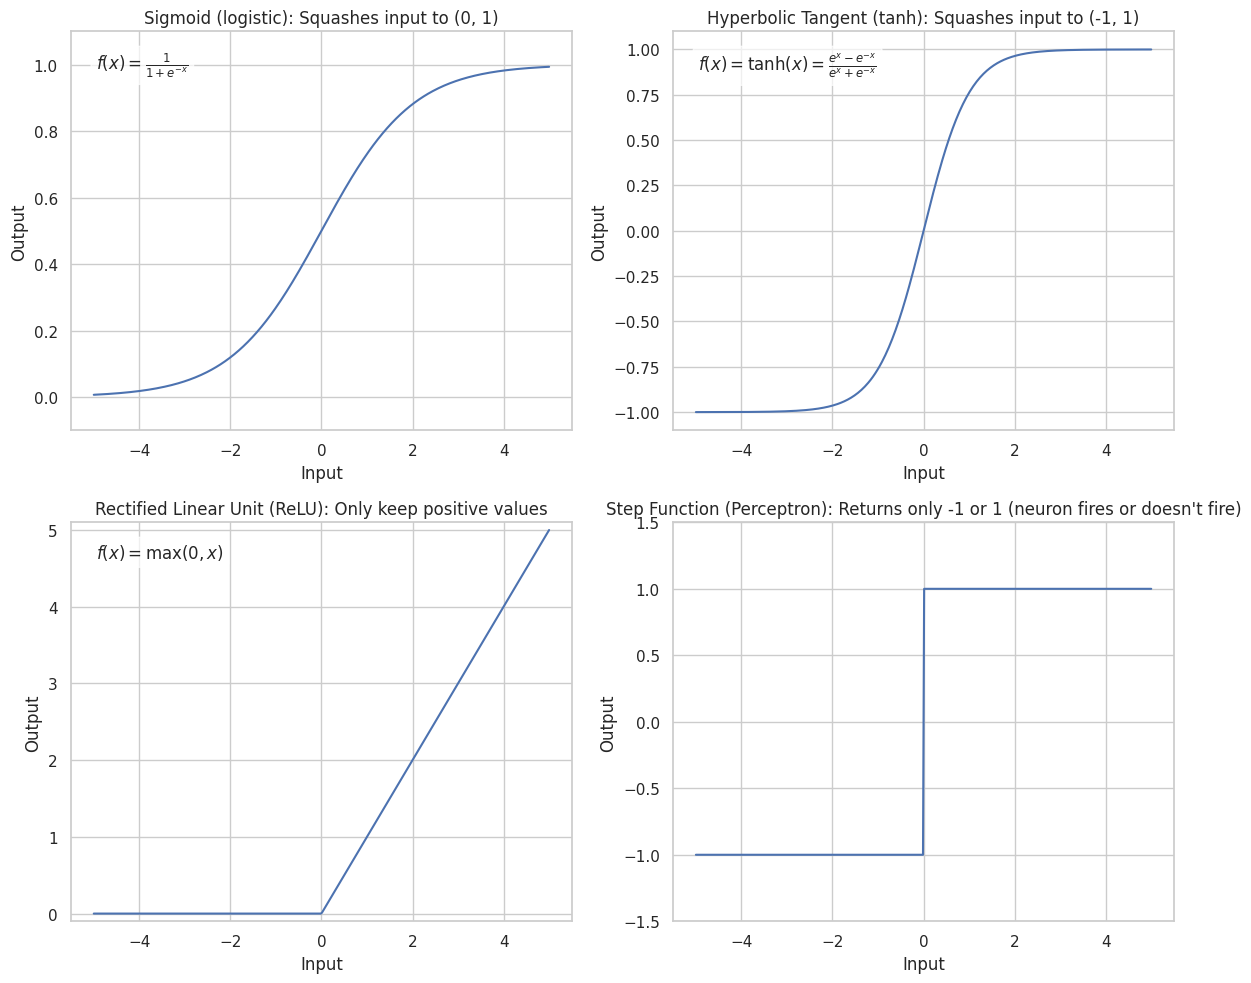

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def step_function(x):
    return np.where(x >= 0, 1, -1)

# Generate input values
x = np.linspace(-5, 5, 400)

# Create figure and axes for 4 subplots
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Sigmoid
axs[0, 0].plot(x, sigmoid(x), label="Sigmoid")
axs[0, 0].set_title("Sigmoid (logistic): Squashes input to (0, 1)")
axs[0, 0].set_ylim([-0.1, 1.1])
axs[0, 0].text(0.05, 0.95, r'$f(x) = \frac{1}{1 + e^{-x}}$', 
               transform=axs[0, 0].transAxes, 
               verticalalignment='top', 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Plot Tanh
axs[0, 1].plot(x, tanh(x), label="Tanh")
axs[0, 1].set_title("Hyperbolic Tangent (tanh): Squashes input to (-1, 1)")
axs[0, 1].set_ylim([-1.1, 1.1])
axs[0, 1].text(0.05, 0.95, r'$f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$', 
               transform=axs[0, 1].transAxes, 
               verticalalignment='top', 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Plot ReLU
axs[1, 0].plot(x, relu(x), label="ReLU")
axs[1, 0].set_title("Rectified Linear Unit (ReLU): Only keep positive values")
axs[1, 0].set_ylim([-0.1, 5.1])
axs[1, 0].text(0.05, 0.95, r'$f(x) = \max(0, x)$', 
               transform=axs[1, 0].transAxes, 
               verticalalignment='top', 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Plot Step Function
axs[1, 1].plot(x, step_function(x), label="Step Function")
axs[1, 1].set_title("Step Function (Perceptron): Returns only -1 or 1 (neuron fires or doesn't fire)")
axs[1, 1].set_ylim([-1.5, 1.5])

# Set a consistent label for x and y axes
for ax in axs.flat:
    ax.set_xlabel("Input")
    ax.set_ylabel("Output")

# Adjust layout
plt.tight_layout()

# Display the figure
plt.show()    

In [32]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    model.train()
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        
        model.train()
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, num_epochs+1), y=train_losses, label='Train Loss')
    sns.lineplot(x=range(1, num_epochs+1), y=val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('figures/ch08/loss_curves_sns.png', bbox_inches='tight', dpi=600)
    plt.savefig('figures/ch08/loss_curves_sns.pdf', bbox_inches='tight', dpi=600);
    plt.close()

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50)

Epoch 1/50, Train Loss: 3.7013, Val Loss: 0.9655
Epoch 2/50, Train Loss: 1.0446, Val Loss: 0.8682
Epoch 3/50, Train Loss: 0.8746, Val Loss: 0.8960
Epoch 4/50, Train Loss: 0.7695, Val Loss: 0.7954
Epoch 5/50, Train Loss: 0.6943, Val Loss: 0.7483
Epoch 6/50, Train Loss: 0.6263, Val Loss: 0.7786
Epoch 7/50, Train Loss: 0.5776, Val Loss: 0.7812
Epoch 8/50, Train Loss: 0.5352, Val Loss: 0.8359
Epoch 9/50, Train Loss: 0.5434, Val Loss: 1.0827
Epoch 10/50, Train Loss: 0.5252, Val Loss: 0.7844
Epoch 11/50, Train Loss: 0.5197, Val Loss: 0.7017
Epoch 12/50, Train Loss: 0.4966, Val Loss: 0.7505
Epoch 13/50, Train Loss: 0.4566, Val Loss: 0.7817
Epoch 14/50, Train Loss: 0.4588, Val Loss: 0.7388
Epoch 15/50, Train Loss: 0.5069, Val Loss: 0.7325
Epoch 16/50, Train Loss: 0.4434, Val Loss: 0.7094
Epoch 17/50, Train Loss: 0.4260, Val Loss: 0.7432
Epoch 18/50, Train Loss: 0.3724, Val Loss: 0.7062
Epoch 19/50, Train Loss: 0.3394, Val Loss: 0.6851
Epoch 20/50, Train Loss: 0.3268, Val Loss: 0.7101
Epoch 21/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss: 0.9235
Mean Squared Error: 0.9249
Mean Absolute Error: 0.7274
R-squared: 0.5685


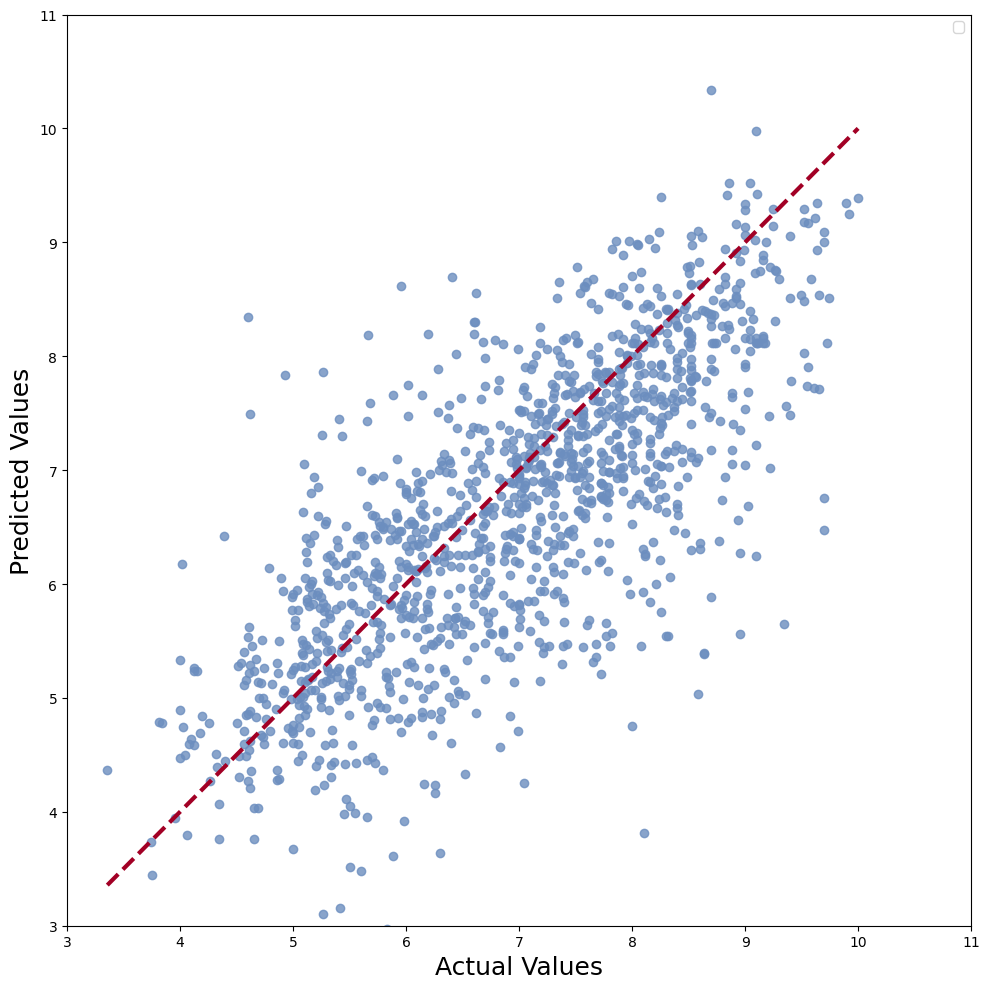

In [41]:
# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    r2 = np.corrcoef(predictions, actuals)[0, 1]**2
    
    print(f'Test Loss: {total_loss/len(test_loader):.4f}')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'R-squared: {r2:.4f}')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(actuals, predictions, alpha=0.8, color="#6C8EBF")
    ax.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], '--', lw=3)
    ax.set_xlabel("Actual Values", fontsize=18)
    ax.set_ylabel("Predicted Values", fontsize=18)
    ax.set_xlim([3, 11])
    ax.set_ylim([3, 11])
    ax.legend(loc="best")
    plt.tight_layout()
    plt.savefig('figures/ch08/lbvs_scatter.png', bbox_inches='tight', dpi=600)
    plt.savefig('figures/ch08/lbvs_scatter.pdf', bbox_inches='tight', dpi=600);

evaluate_model(model, test_loader, criterion, device)

In [27]:
# Save the trained model
torch.save(model.state_dict(), 'artifacts/ch08/kinase_binder_model.pth')
print("Model saved successfully.")

Model saved successfully.


In [28]:
loaded_model = KinaseBinderNN()
loaded_model.load_state_dict(torch.load('artifacts/ch08/kinase_binder_model.pth'))
loaded_model.eval()  # Set the model to evaluation mode

/tmp/ipykernel_840/1704290042.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('artifacts/ch08/kinase_binder_model.pth'))


KinaseBinderNN(
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

### Enrichment Factors in Virtual Screening

In [40]:
def evaluate_model_enrichment(model, test_loader, criterion, device, activity_threshold=6.3):
    model.eval()
    total_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    r2 = np.corrcoef(predictions, actuals)[0, 1]**2
    
    logger.info(f'Test Loss: {total_loss/len(test_loader):.4f}')
    logger.info(f'Mean Squared Error: {mse:.4f}')
    logger.info(f'Mean Absolute Error: {mae:.4f}')
    logger.info(f'R-squared: {r2:.4f}')

    return predictions, actuals

2024-09-12 11:02:22,015 - INFO - Test Loss: 0.9235
2024-09-12 11:02:22,017 - INFO - Mean Squared Error: 0.9249
2024-09-12 11:02:22,018 - INFO - Mean Absolute Error: 0.7274
2024-09-12 11:02:22,019 - INFO - R-squared: 0.5685


Enrichment Factors:
EF0.5%:
  Model:  1.53
  Optimal: 1.53
  Random:  1.00
EF1.0%:
  Model:  1.53
  Optimal: 1.53
  Random:  1.00
EF2.0%:
  Model:  1.53
  Optimal: 1.53
  Random:  1.00
EF5.0%:
  Model:  1.53
  Optimal: 1.53
  Random:  1.00
EF50.0%:
  Model:  1.43
  Optimal: 1.53
  Random:  1.00
Found actives (%) for top 5% of ranked data set:
  Model:  7.64
  Optimal:  7.64
  Random:  5.00


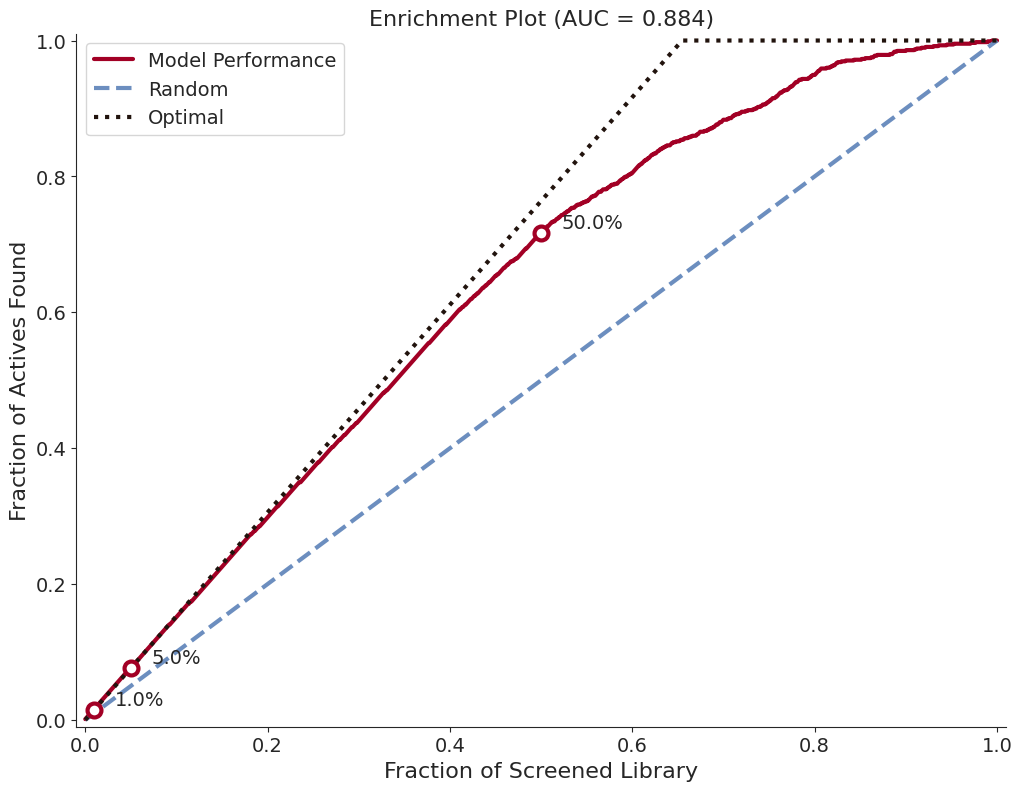

In [64]:
from sklearn.metrics import roc_curve, auc

def create_enrichment_plot(y_true, y_pred, activity_threshold=6.3, ef_percentages=[0.005, 0.01, 0.02, 0.05]):
    # Convert continuous predictions to binary (active/inactive)
    y_true_binary = (y_true >= activity_threshold).astype(int)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Calculate enrichment curve
    sorted_indices = np.argsort(y_pred)[::-1]
    n_actives = np.sum(y_true_binary)
    n_total = len(y_true_binary)
    
    x_values = np.linspace(0, 1, n_total)
    y_values = np.cumsum(y_true_binary[sorted_indices]) / n_actives
    
    # Set up the plot style
    sns.set_style("ticks")
    plt.figure(figsize=(12, 9))
    
    # Plot enrichment curve
    sns.lineplot(x=x_values, y=y_values, label='Model Performance', linewidth=3)
    sns.lineplot(x=[0, 1], y=[0, 1], label='Random', linestyle='--', linewidth=3)
    sns.lineplot(x=[0, n_actives/n_total, 1], y=[0, 1, 1], label='Optimal', linestyle=':', linewidth=3)
    sns.despine()

    # Add dots for EF percentages
    for percentage in ef_percentages:
        index = int(n_total * percentage)
        plt.plot(percentage, y_values[index], 'o', markersize=10, 
                 markerfacecolor='white', markeredgecolor='#A20025', markeredgewidth=3)
        plt.annotate(f'{percentage*100:.1f}%', (percentage, y_values[index]), 
                     xytext=(15, 3), textcoords='offset points', fontsize=14)
    
    plt.xlabel('Fraction of Screened Library', fontsize=16)
    plt.ylabel('Fraction of Actives Found', fontsize=16)
    plt.title(f'Enrichment Plot (AUC = {roc_auc:.3f})', fontsize=16)
    plt.legend(fontsize=14)
    
    # Adjust plot limits and ticks
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/ch08/enrichment_plot.png', bbox_inches='tight', dpi=600)
    plt.savefig('figures/ch08/enrichment_plot.pdf', bbox_inches='tight', dpi=600)
    return plt

def calculate_enrichment_factors(y_true, y_pred, activity_threshold=6.3, ef_percentages=[0.005, 0.01, 0.02, 0.05]):
    y_true_binary = (y_true >= activity_threshold).astype(int)
    sorted_indices = np.argsort(y_pred)[::-1]
    n_actives = np.sum(y_true_binary)
    n_total = len(y_true_binary)
    
    enrichment_factors = {}
    for percentage in ef_percentages:
        n_compounds = int(n_total * percentage)

        # Model performance
        n_actives_found = np.sum(y_true_binary[sorted_indices[:n_compounds]])
        ef_model = (n_actives_found / n_compounds) / (n_actives / n_total)
        
        # Optimal performance (all actives at the top)
        ef_optimal = min(1 / percentage, n_total / n_actives)
        
        # Random performance
        ef_random = 1.0  # By definition, random selection has an enrichment factor of 1
        
        enrichment_factors[f"EF{percentage*100:.1f}%"] = {
            "Model": ef_model,
            "Optimal": ef_optimal,
            "Random": ef_random
        }
    
    return enrichment_factors

predictions, actuals = evaluate_model_enrichment(loaded_model, test_loader, criterion, device)

# Calculate and print enrichment factors
ef_percentages=[0.005, 0.01, 0.02, 0.05, 0.5]
ef = calculate_enrichment_factors(actuals, predictions, ef_percentages=ef_percentages)

# Create and show enrichment plot
plt = create_enrichment_plot(actuals, predictions, ef_percentages=[0.01, 0.05, 0.5])

print("Enrichment Factors:")
for k, v in ef.items():
    print(f"{k}:")
    print(f"  Model:  {v['Model']:.2f}")
    print(f"  Optimal: {v['Optimal']:.2f}")
    print(f"  Random:  {v['Random']:.2f}")

print("Found actives (%) for top 5% of ranked data set:")
for k, v in ef["EF5.0%"].items():
    print(f"  {k}:  {v * 5:.2f}")

## 2️⃣ Neural Networks & PyTorch Mechanics

*Companion code for this section of the book is already referenced within the earlier parts of this notebook.*